In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

2023-08-07 14:46:52.648790: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 14:46:53.107955: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
train_image_path = glob.glob('/home/jhr/Documents/data/dc_2000/train/*/*.jpg')
train_image_label = [int(p.split('/')[-1].split('.')[0] == 'cat')
                     for p in train_image_path]
train_image_label[:5],len(train_image_path)

([1, 1, 1, 1, 1], 2000)

In [3]:
train_image_path_test = glob.glob('/home/jhr/Documents/data/dc_2000/test/*/*.jpg')
train_image_label_test  = [int(p.split('/')[-1].split('.')[0] == 'cat')
                     for p in train_image_path_test ]

train_image_label_test [:5],len(train_image_path_test)

([1, 1, 1, 1, 1], 1000)

In [4]:
#图片增强
def load_precess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    # image = tf.image.random_crop(image, [256, 256, 3])  # 随机裁剪
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    # image = tf.image.random_brightness(image, 0.5)
    # image = tf.image.random_hue(image,0.5)
    # image = tf.image.random_contrast(image, 0, 1)
    image = tf.cast(image, tf.float32)
    image = image/255  # 归一化
    label = tf.reshape(label, [1])
    return image, label

def load_precess_image_test(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32)
    image = image/255  # 归一化
    label = tf.reshape(label, [1])
    return image, label

In [5]:
dataset = tf.data.Dataset.from_tensor_slices(
    (train_image_path, train_image_label))
AUTOTUNE = tf.data.experimental.AUTOTUNE
dataset = dataset.map(load_precess_image,
                      num_parallel_calls=AUTOTUNE)

2023-08-07 14:46:53.865843: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-07 14:46:53.884380: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-07 14:46:53.884516: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
dataset_test = tf.data.Dataset.from_tensor_slices(
    (train_image_path_test, train_image_label_test))
dataset_test = dataset_test.map(load_precess_image_test,
                      num_parallel_calls=AUTOTUNE)

In [7]:
step=32
dataset=dataset.shuffle(2000).repeat().batch(step)
dataset_test=dataset_test.batch(step)

In [8]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))>

In [9]:
dataset_test

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))>

通过trainable参数，冻结vgg16模型的卷积层参数，只对我们后续添加的分类层进行训练，
从而提高训练速度，提高训练精度

In [10]:
covn_base = tf.keras.applications.VGG16(weights='imagenet', include_top=False)
covn_base.trainable = False  # 设定不可训练
# covn_base.summary()

In [11]:
model = tf.keras.Sequential()
model.add(covn_base)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14977857 (57.14 MB)
Trainable params: 263169 (1.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['acc'])

In [14]:
# import os
# import datetime
# log_dir = os.path.join(
#     'logs', datetime.datetime.now().strftime("%Y%m%d-%H:%M:%S"))

# tensorboard_callback = tf.keras.callbacks.TensorBoard(
#     log_dir=log_dir, histogram_freq=1)

# # 创建文件编写器
# file_writer = tf.summary.create_file_writer(log_dir+'/lr')
# file_writer.set_as_default()

In [15]:
history = model.fit_generator(dataset,
                              steps_per_epoch=2000//step,
                              epochs=20,
                              validation_data=dataset_test,
                              validation_steps=1000//step,
                              # callbacks=[tensorboard_callback]
             )

Epoch 1/20


/tmp/ipykernel_65105/2652401104.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(dataset,
2023-08-07 14:46:56.795046: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8801
2023-08-07 14:46:58.727174: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-07 14:46:58.735786: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1e5c33c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-07 14:46:58.735799: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-08-07 14:46:58.743906: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproduc

62/62 [==============================] - 17s 211ms/step - loss: 0.5592 - acc: 0.7026 - val_loss: 0.3896 - val_acc: 0.8508
Epoch 2/20
62/62 [==============================] - 13s 209ms/step - loss: 0.4178 - acc: 0.8211 - val_loss: 0.3040 - val_acc: 0.8780
Epoch 3/20
62/62 [==============================] - 13s 209ms/step - loss: 0.3583 - acc: 0.8513 - val_loss: 0.2645 - val_acc: 0.8921
Epoch 4/20
62/62 [==============================] - 13s 211ms/step - loss: 0.3261 - acc: 0.8579 - val_loss: 0.2793 - val_acc: 0.8770
Epoch 5/20
62/62 [==============================] - 13s 210ms/step - loss: 0.3055 - acc: 0.8684 - val_loss: 0.2635 - val_acc: 0.8881
Epoch 6/20
62/62 [==============================] - 13s 211ms/step - loss: 0.2809 - acc: 0.8831 - val_loss: 0.2291 - val_acc: 0.8982
Epoch 7/20
62/62 [==============================] - 13s 211ms/step - loss: 0.2744 - acc: 0.8836 - val_loss: 0.2201 - val_acc: 0.9083
Epoch 8/20
62/62 [==============================] - 13s 211ms/step - loss: 0.275

In [16]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

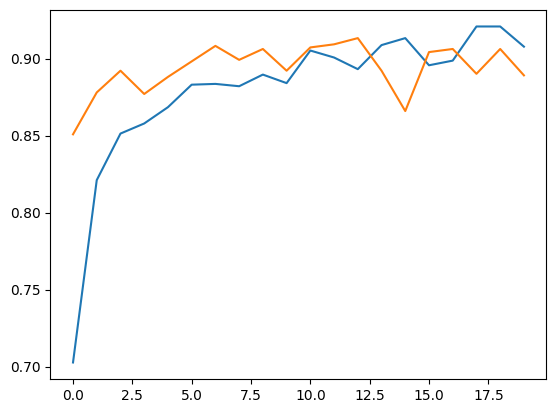

In [17]:
plt.plot(history.epoch,history.history.get('acc'),label='acc')
plt.plot(history.epoch,history.history.get('val_acc'),label='val_acc')

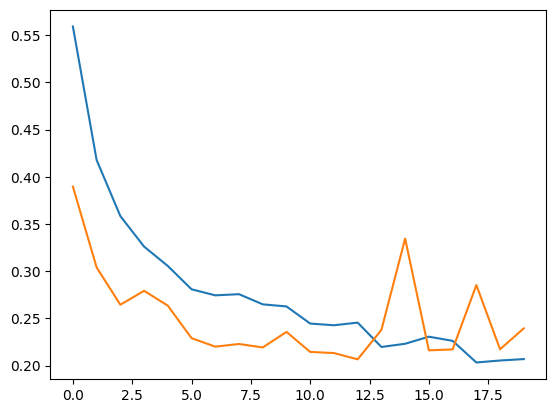

In [18]:
plt.plot(history.epoch,history.history.get('loss'),label='loss')
plt.plot(history.epoch,history.history.get('val_loss'),label='val_loss')

## 微调模型

In [19]:
covn_base.trainable=True

In [20]:
len(covn_base.layers)

19

In [21]:
#封锁分类层
fine_tune_at = -3
for layers in covn_base.layers[:fine_tune_at]:
  layers.trainable=False

In [22]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.0005/10),
              metrics=['acc'])

In [23]:
initial_epochs=20#已经训练的次数
fine_tune_epochs=15#再次训练次数
total_epochs=initial_epochs+fine_tune_epochs

history = model.fit_generator(dataset,
                              steps_per_epoch=2000//step,
                              epochs=total_epochs,
                              initial_epoch=initial_epochs,
                              validation_data=dataset_test,
                              validation_steps=1000//step,
                              # callbacks=[tensorboard_callback]
             )

Epoch 21/35


/tmp/ipykernel_65105/1729259215.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(dataset,


62/62 [==============================] - 15s 203ms/step - loss: 2.5305 - acc: 0.5156 - val_loss: 0.6340 - val_acc: 0.7853
Epoch 22/35
62/62 [==============================] - 12s 202ms/step - loss: 0.5072 - acc: 0.7510 - val_loss: 0.3056 - val_acc: 0.8710
Epoch 23/35
62/62 [==============================] - 12s 202ms/step - loss: 0.3724 - acc: 0.8352 - val_loss: 0.2800 - val_acc: 0.8861
Epoch 24/35
62/62 [==============================] - 12s 203ms/step - loss: 0.2960 - acc: 0.8770 - val_loss: 0.2127 - val_acc: 0.9083
Epoch 25/35
62/62 [==============================] - 12s 203ms/step - loss: 0.2673 - acc: 0.8861 - val_loss: 0.1913 - val_acc: 0.9204
Epoch 26/35
62/62 [==============================] - 12s 202ms/step - loss: 0.2369 - acc: 0.9047 - val_loss: 0.3420 - val_acc: 0.8508
Epoch 27/35
62/62 [==============================] - 12s 202ms/step - loss: 0.2384 - acc: 0.9083 - val_loss: 0.6192 - val_acc: 0.7933
Epoch 28/35
62/62 [==============================] - 12s 202ms/step - loss

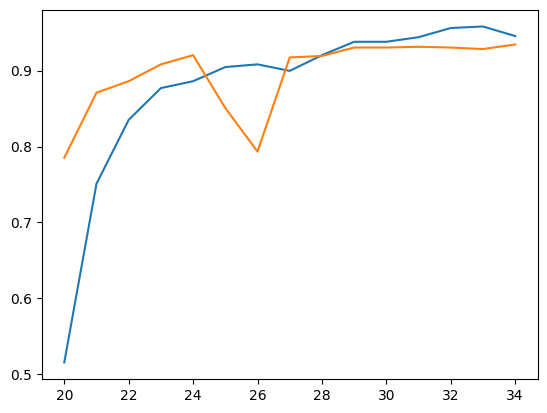

In [24]:
plt.plot(history.epoch,history.history.get('acc'),label='acc')
plt.plot(history.epoch,history.history.get('val_acc'),label='val_acc')

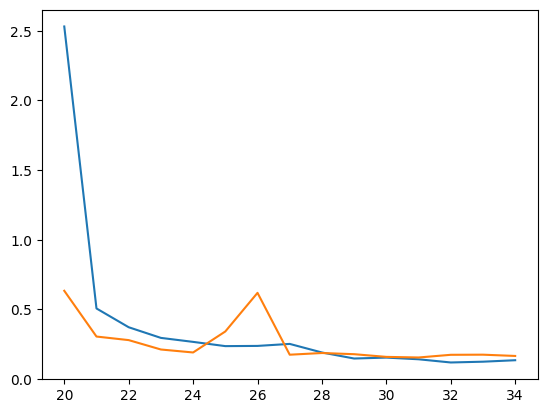

In [25]:
plt.plot(history.epoch,history.history.get('loss'),label='loss')
plt.plot(history.epoch,history.history.get('val_loss'),label='val_loss')